1.	Write a function file that returns the potential energy. Apply Nelder–Mead to find the minimal energy for n = 5. Try several initial guesses until you are convinced you have the absolute minimum. How many steps are required?

First, we'll make a Nelder-Mead method:

In [ ]:
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings("ignore")

#function takes in list of triplets representing atom locations, outputs the total potential
def g(atoms):
  n = len(atoms)
  pototal = 0
  for i in range(n - 1):
    for j in range(i + 1,n):
      d = atoms[i]-atoms[j]
      r = np.inner(d,d)
      pototal += (r**-6 - 2 * r**-3)
  return pototal

# A simple helper function that returns a guess for the descent methods
def getGuess(n, max, min):
    width = (max-min)
    rands = width*np.random.rand(3*n-5) + min
    return np.append(np.zeros(5),rands).reshape(n,3)

In [ ]:
#Implementation of Nelder-Mead. Assumes func takes in ordered triplets
def NM(n,func=g, max=2, min=-2, tol=1e-15, iters=10**5, reflect=1, expand=2, contract=0.5, shrink=0.5, guess=[], off=1):

  #if we don't already have a guess, generate a random one filling in the values randomly from the minimum to the maximum
  if (len(guess) == 0):
    guess = getGuess(n, max, min)

  #function that creates a nx3 array with a +/-off in the specified position
  def inc(place):
    incr = -1**np.random.randint(2) * off
    return np.append(np.append(np.zeros(place-1), [incr]),np.zeros(3*n-place)).reshape((n,3))

  #take the guess and for each variable shift it randomly by +/-off for that variable to get the starting vertices of the simplex
  guesses = [guess]
  for i in range(3*n-5):
    guesses = guesses + [guess+inc((6+i))]
  guesses = np.array(guesses)

  #evaluate all of them
  outputs = []
  for e in guesses:
    outputs.append(func(e))
  outputs = np.array(outputs)

  #sort in ascending order
  indx = np.argsort(outputs)
  guesses = guesses[indx]
  outputs = outputs[indx]
  for iter in range(iters):
    if(np.abs(outputs[0] - outputs[-1]) < tol):
      return guesses[0], iter

    centroid = np.zeros((n,3))
    for i in range(len(guesses)-1):
      centroid += guesses[i]
    centroid = centroid/(3*n-5)

    reflection = centroid + reflect*(centroid - guesses[-1])
    out = g(reflection)

    #if the reflection is between the best and second worst, replace the worst with it and then sort
    if (outputs[0] < out < outputs[-2]):
      guesses[-1] = reflection
      outputs[-1] = out
      indx = np.argsort(outputs)
      guesses = guesses[indx]
      outputs = outputs[indx]
      continue

    #if the reflection is the new best, try expanding. If that doesn't work just use the reflected point
    elif(out <= outputs[0]):
      expansion = centroid + expand*(reflection - centroid)
      expout = g(expansion)
      if(expout < out):
        guesses[-1] = expansion
        outputs[-1] = expout
        indx = np.argsort(outputs)
        guesses = guesses[indx]
        outputs = outputs[indx]
      else:
        guesses[-1] = reflection
        outputs[-1] = out
        indx = np.argsort(outputs)
        guesses = guesses[indx]
        outputs = outputs[indx]
      continue

    #if the reflected point is worse than the second worst point, contract. If that improves things then use the contracted point.
    else:
      contraction = centroid + contract*(guesses[-1] - centroid)
      controut = g(contraction)
      if(controut < outputs[-1]):
        guesses[-1] = contraction
        outputs[-1] = controut
        indx = np.argsort(outputs)
        guesses = guesses[indx]
        outputs = outputs[indx]
        continue

    #if contraction didn't work, shrink the simplex
    for i in range(1,len(guesses)):
      guesses[i] = guesses[0] + shrink*(guesses[i] - guesses[0])

  return guesses[0], iters

Now, we'll test Nelder-Mead with n=5:

In [ ]:
t0 = time.time()
result = NM(5)[0]
print("\nMinimum Conformation =\n", result[0],"\n")
print("Time (seconds) =", time.time() - t0)
print("Iterations =",result[1])
print("Minimum Lennard-Jones Potential =", g(result[0]))


Minimum Conformation =
 [[ 0.          0.          0.        ]
 [ 0.          0.         -1.00145352]
 [-0.85674023  0.10529504 -0.50072675]
 [ 0.7309983   0.45905593 -0.50072676]
 [-0.18861289  0.84652646 -0.50072677]] 

Time (seconds) = 14.538931131362915
Iterations = 100000
Minimum Lennard-Jones Potential = -9.103852415707557


After a couple thousand iterations (usually about 5000), it attains a minimum of about -9.1038

2.	Plot the five atoms in the minimum energy configuration as circles, and connect all circles with line segments to view the conformed molecule.



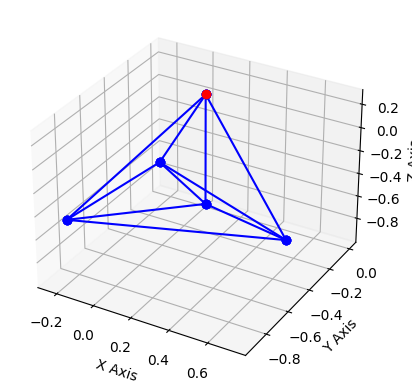

In [ ]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x,y,z=result.T

for i in range(len(result)-1):
  for j in range(i+1, len(result)):
    ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], c='b', marker='o')

#plot the origin in red
ax.plot([0],[0],[0],marker='o',color='red')

yy, zz = np.meshgrid(range(-1,2), range(-1,2))
xx = yy*0

# Set labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()

3.	Extend the function in Step 1 so that it returns f and the gradient vector ∇ f . Apply different versions of the Gradient Descent method for the n = 5 case. Find the minimum energy as before.

The gradient can be calculated explicitly. For n points we have 3n-5 independent values. The function is 𝝨(1/r^12 - 2/r^6) for all pairs of atoms, so taking the derivative wrt one dimension of one atom will kill off all terms not including that atom, which means that we have just the above sum for pairs including the atom with the dimension under consideration. Then you just need to take the derivatives of the remaining terms individually. The total derivative will be the sum of the derivatives of the 1/r^12 terms, minus twice the sum of the derivatives of the 1/r^6 terms. The derivative of the former is given below as "smallterm" and the latter as "largeterm".

In [ ]:
def smallterm(x,a,c):
  return (-12*(x-a)) / ((x-a)**2 + c)**7

def largeterm(x,a,c):
  return (-6*(x-a)) / ((x-a)**2 + c)**4

In [ ]:
#function that returns the gradient at that point
def gradient(atoms):
  n = len(atoms)

  var = atoms[1][2]
  gr = 0
  for j in chain(range(1), range(2,n)):
    othera = atoms[j]
    a = othera[2]
    c = othera[0]**2 + othera[1]**2
    gr += smallterm(var,a,c) - 2*largeterm(var,a,c)
  grad = [gr]

  for i in range(2,n):
    atom = atoms[i]
    for dim in range(3):
      gr = 0
      var = atom[dim]
      for j in chain(range(i), range(i+1,n)):
        othera = atoms[j]
        a = othera[dim]
        c = 0
        for d in chain(range(dim),range(dim+1,3)):
          c += (atom[d]-othera[d])**2
        gr += smallterm(var,a,c) - 2*largeterm(var,a,c)
      grad.append(gr)

  grad = np.append(np.array([0,0,0,0,0]),grad).reshape(n,3)
  return grad

In [ ]:
#this gets stuck on some saddle point around f(xyzs) = -6.0, -3.0
# The method take a function (func), the gradient of a function and computes the minimum conformation
def fixedDescent(n, func=g, gradient=gradient, iters=10**5, tol=1e-4, guess=[], min=-3, max=3, inc=0.008):

  if (len(guess) == 0):
    guess = getGuess(n, max, min)

  for iter in range(iters):
    val, grad = func(guess), gradient(guess)

    #stopping criterion
    if(np.sum(np.abs(grad)) < tol):
      return guess, iter

    #Here, we're just incrementing by a set amount, nothing fancy
    guess = guess - inc*grad

  return guess, iters

In [ ]:
def backtrackingDescent(n, func=gradient, iters=10**5, tol=1e-4, guess=[], min=-3, max=3, step_size=0.05, alpha = 0.3, beta = 0.8):
  if (len(guess) == 0):
    guess = getGuess(n, max, min)

  for iter in range(iters):
    val, grad = g(guess), func(guess)

    #stopping criterion
    if(np.sum(np.abs(grad)) < tol):
      return guess, iter

    #Compare the current step size in the function to the linear approximation
    if g(guess - step_size * grad) > val - alpha * step_size * np.linalg.norm(grad)**2:
      step_size *= beta
    guess = guess - step_size*grad
  return guess, iters

In [ ]:
# Golden Section Search method that will be used by the descent with search
def goldsearch(f, min, max, tol=1e-4, iters=10**3):
  gratio = (np.sqrt(5) - 1)/2

  goldval = (max-min) * gratio
  guess1 = min + goldval
  guess2 = max - goldval
  v1 = f(guess1)
  v2 = f(guess2)
  for iter in range(iters):
    #stopping criterion
    if(np.abs(min-max) < tol):
      return (min+max)/2

    if(v1 < v2):
      min = guess2
      guess2 = guess1
      v2 = v1
      goldval = (max-min) * gratio
      guess1 = min + goldval
      v1 = f(guess1)

    else:
      max = guess1
      guess1 = guess2
      v1 = v2
      goldval = (max-min) * gratio
      guess2 = max - goldval
      v2 = f(guess2)
  return (min+max)/2

In [ ]:
def descentWithSearch(n, func=gradient, iters=10**4, tol=1e-4, guess=[], min=-2, max=2, inc=0.1):
  if (len(guess) == 0):
    guess = getGuess(n, max, min)

  for iter in range(iters):
    val, grad = g(guess), func(guess)

    #stop if the function is too flat
    if(np.sum(np.abs(grad)) < tol):
      return guess, iter

    def f(s):
      return g(guess - s*grad)

    di = inc
    max_iter = 5000
    while(f(0) > f(di) and max_iter>0):
      di+=inc
      max_iter -=1

    #Here, we'll use the Golden Section Search to minimize f, ensuring quicker convergence
    jump = goldsearch(f,0,di,tol=1e-4,iters=100)
    guess = guess - jump*grad

  return guess, iters

We'll test out the fixed descent method:

In [ ]:
# x0 = np.array([[0.0,0,0],[0,0,1],[1,-1,1],[-1,-1,1],[0.9,1,1.2]])
t0 = time.time()
result = fixedDescent(5)
print("\nMinimum Conformation =\n", result[0],"\n")
print("Time (seconds) =", time.time() - t0)
print("Iterations =",result[1])
print("Minimum Lennard-Jones Potential =", g(result[0]))


Minimum Conformation =
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.99706919]
 [ 0.89592511 -0.28573957 -0.32388318]
 [ 0.52180644 -0.6875665   0.50035641]
 [ 0.82353559  0.2584933   0.50035641]] 

Time (seconds) = 24.532065391540527
Iterations = 100000
Minimum Lennard-Jones Potential = -9.094928310605088


Now, we'll test the backtracking descent method:

In [ ]:
# x0 = np.array([[0.0,0,0],[0,0,1],[-0.5,1,1],[0,-1,0],[-1,0,0]])
t0 = time.time()
result = backtrackingDescent(5)
print("\nMinimum Conformation =\n", result[0],"\n")
print("Time (seconds) =", time.time() - t0)
print("Iterations =",result[1])
print("Minimum Lennard-Jones Potential =", g(result[0]))


Minimum Conformation =
 [[ 0.          0.          0.        ]
 [ 0.          0.         -0.99790645]
 [-0.86148011 -0.3823015  -1.32580333]
 [-0.44300185 -0.74440984 -0.4953992 ]
 [-0.84921725  0.17095822 -0.49539928]] 

Time (seconds) = 0.7750656604766846
Iterations = 2707
Minimum Lennard-Jones Potential = -9.103852415649355


Lastly, we'll test out the descent with golden section search method:

In [ ]:
# x0 = np.array([[0.0,0,0],[0,0,1],[1,-1,1],[-1,-1,1],[0.9,1,1.2]])
t0 = time.time()
result = descentWithSearch(5)
print("\nMinimum Conformation =\n", result[0],"\n")
print("Time (seconds) =", time.time() - t0)
print("Iterations =",result[1])
print("Minimum Lennard-Jones Potential =", g(result[0]))

Iterations Run = 344

Minimum Conformation =
 [[ 0.          0.          0.        ]
 [ 0.          0.         -0.99790644]
 [-0.80627858 -0.48807198  0.32789992]
 [-0.34540826 -0.79441177 -0.50250554]
 [-0.86401115  0.06230289 -0.50250553]] 

Time (seconds) = 0.38912510871887207
Iterations = 344
Minimum Lennard-Jones Potential = -9.10385241567574


4.	Apply the previous methods to n = 6. Rank the methods according to reliability and efficiency.

In [ ]:
n = 6

def methodCaller(f, n, name, iter = 5):
  overall_time = 0
  min = 0
  iterations = 0

  for i in range(iter):
    t0 = time.time()
    result, iterations0 = f(n)
    overall_time += time.time() - t0
    iterations+=iterations0
    min+=g(result)

  print("\n\n",name,"\n")
  print("Time (seconds) =", overall_time/iter)
  print("Iterations =", iterations/iter)
  print("Minimum Lennard-Jones Potential =", min/iter)

methodCaller(NM, n, "Nelder-Mead")
methodCaller(fixedDescent,n,"Fixed Descent")
methodCaller(backtrackingDescent, n, "Backtracking Descent")
methodCaller(descentWithSearch, n, "Descent with Golden Section Search")



 Nelder-Mead 

Time (seconds) = 15.916435813903808
Iterations = 81302.0
Minimum Lennard-Jones Potential = -11.374090315187704


 Fixed Descent 

Time (seconds) = 22.545502996444704
Iterations = 60448.2
Minimum Lennard-Jones Potential = -9.119564277421912


 Backtracking Descent 

Time (seconds) = 9.687003421783448
Iterations = 21919.0
Minimum Lennard-Jones Potential = -11.023297483961564


 Descent with Golden Section Search 

Time (seconds) = 0.6764023780822754
Iterations = 464.4
Minimum Lennard-Jones Potential = -10.442342032084392


See Project Report for results and reliability + efficiency rankings.

5.	Determine and plot minimum-energy conformations for larger n. Information on minimum-energy Lennard-Jones clusters for n up to several hundred is posted at several Internet sites, so your answers can be readily checked.

Now, we'll check which methods perform best when n = 8:

In [ ]:
n = 8
iter = 2

methodCaller(NM, n, "Nelder-Mead", iter=2)
methodCaller(fixedDescent,n,"Fixed Descent", iter=2)
methodCaller(backtrackingDescent, n, "Backtracking Descent", iter=2)
methodCaller(descentWithSearch, n, "Descent with Golden Section Search", iter=2)



 Nelder-Mead 

Time (seconds) = 31.100504398345947
Iterations = 100000.0
Minimum Lennard-Jones Potential = -13.974084792471732


 Fixed Descent 

Time (seconds) = 57.17216811180115
Iterations = 81095.8
Minimum Lennard-Jones Potential = -12.349990251335278


 Backtracking Descent 

Time (seconds) = 3.5088733434677124
Iterations = 4716.0
Minimum Lennard-Jones Potential = -17.67727462328235


 Descent with Golden Section Search 

Time (seconds) = 15.691316366195679
Iterations = 5102.0
Minimum Lennard-Jones Potential = -10.705404861767763


Now to plot configurations for higher n using backtracking

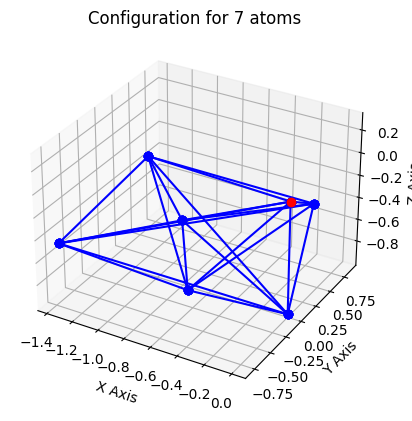

In [ ]:
for n in range(6, 10):
  result = backtrackingDescent(n)[0]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  x,y,z=result.T

  for i in range(len(result)-1):
    for j in range(i+1, len(result)):
      ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], c='b', marker='o')

  #plot the origin in red
  ax.plot([0],[0],[0],marker='o',color='red')

  yy, zz = np.meshgrid(range(-1,2), range(-1,2))
  xx = yy*0

  # Set labels
  ax.set_title("Configuration for "+ str(n) + " atoms")
  ax.set_xlabel('X Axis')
  ax.set_ylabel('Y Axis')
  ax.set_zlabel('Z Axis')

  # Show the plot
  plt.show()


Minimum Conformation =
 [[ 0.          0.          0.        ]
 [ 0.          0.          1.6280552 ]
 [ 2.41727052  2.46324462 -2.52919187]
 [ 0.349163    0.45092192  0.8114104 ]
 [ 0.946155   -0.13320087  0.26584565]
 [ 1.06557786 -1.0425815   0.65431629]
 [ 0.40137629 -0.90304684 -0.07703375]
 [ 0.23489837 -0.53602564  0.83097415]
 [-0.5693541   0.04676576  0.81004412]
 [-0.53303346 -0.79497575  0.26789491]] 

Minimum Lennard-Jones Potential = -23.19874439772206


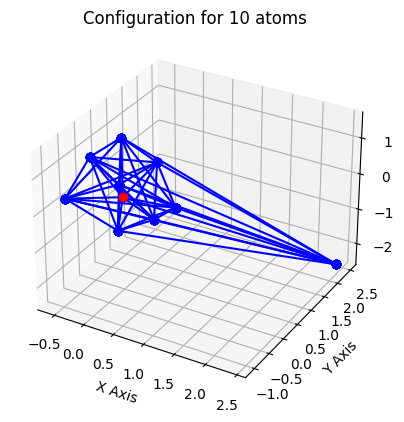


Minimum Conformation =
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.88621402e-01]
 [-2.93126354e-01  8.90228548e-01 -3.23326155e-01]
 [-3.46822879e-01  8.56977127e-01  1.34014665e+00]
 [ 3.77001815e-01 -7.71385890e-01  4.83948678e-01]
 [-7.11629803e-01  4.82937357e-01  4.89411926e-01]
 [-5.44847949e-02 -9.12659506e-01  1.36658887e+00]
 [-3.80993366e+00  8.06883381e+00  5.96124726e+00]
 [ 3.23805077e+03 -8.76644255e+03  1.02534849e+04]
 [ 8.59134345e-01  1.03513139e-01  4.90107719e-01]
 [ 3.70408754e+00 -4.53102948e+00 -7.70786675e+00]
 [ 2.16154808e-01  8.47630411e-01  5.23529878e-01]
 [ 8.22302457e-01 -4.38265011e-01  1.32076065e+00]
 [ 1.36632718e+00 -7.47165296e-01  5.43634638e-01]
 [ 6.78841557e-01  6.38715807e-01 -3.30436912e-01]] 

Minimum Lennard-Jones Potential = -33.30649696681057


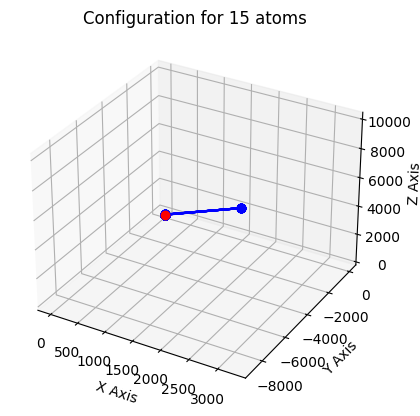


Minimum Conformation =
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.36893643e+01]
 [ 7.44045323e-01 -1.56844853e+00 -9.16558019e-01]
 [ 4.42257914e-01 -7.19163550e-01 -4.95588129e-01]
 [ 2.52854662e-01 -8.62360321e-01 -1.43870170e+00]
 [ 3.95282243e-01 -1.58043859e+00  8.93019926e-03]
 [ 5.72035485e-01 -7.07943318e-01  4.66013237e-01]
 [ 2.97563974e+02  2.39668639e+02 -2.94115837e+02]
 [-1.22184726e+00 -9.99538591e-01  4.94865963e-01]
 [-9.81386538e-01 -1.87152610e-01 -3.18208768e-02]
 [ 4.45875414e+02 -5.04895365e+02  9.15979214e+02]
 [-4.25666272e-01 -4.36897154e-01 -8.11847907e-01]
 [-7.43365303e+02  2.63723340e+02 -6.16775867e+02]
 [-2.22153863e-01 -1.41327561e+00 -7.58918139e-01]
 [ 1.26240626e+00 -1.12482817e+00 -1.72700537e-01]
 [-3.27404270e-01 -9.20800582e-01  8.75992059e-02]
 [-4.79660712e+03  3.24571517e+03 -4.98782686e+03]
 [ 1.20481775e+00 -7.15367973e-01 -1.10516270e+00]
 [ 4.79520573e+03 -3.24104211e+03  4.98566942e+03]
 [-1.1

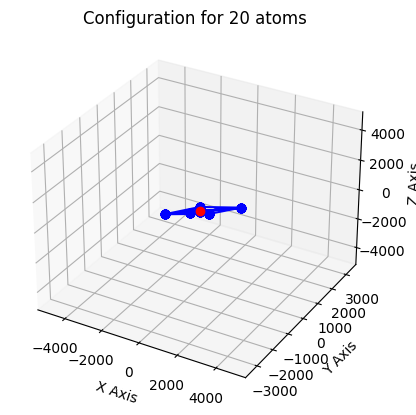

In [ ]:
 for n in [10,15,20]:
  result = backtrackingDescent(n)[0]
  print("\nMinimum Conformation =\n", result,"\n")
  print("Minimum Lennard-Jones Potential =", g(result))

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  x,y,z=result.T

  for i in range(len(result)-1):
    for j in range(i+1, len(result)):
      ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], c='b', marker='o')

  #plot the origin in red
  ax.plot([0],[0],[0],marker='o',color='red')

  yy, zz = np.meshgrid(range(-1,2), range(-1,2))
  xx = yy*0

  # Set labels
  ax.set_title("Configuration for "+ str(n) + " atoms")
  ax.set_xlabel('X Axis')
  ax.set_ylabel('Y Axis')
  ax.set_zlabel('Z Axis')

  # Show the plot
  plt.show()